
### Preparation
✓ Open the SSH terminal and connect to the training VM
Compute Engine > VM instances > Connect
✓ In SSH terminal Verify initialization is complete
```shell
ls /training
```
✓ In SSH terminal Download Code Repository
```shell
git clone https://github.com/GoogleCloudPlatform/training-data-analyst
```
✓ In SSH terminal Identify a project
```shell
export DEVSHELL_PROJECT_ID=$(gcloud config get-value project) 
```

### Create Pub/Sub topic and subscription
1.On the training-vm SSH terminal, navigate to the directory for this lab.
```shell
cd ~/training-data-analyst/courses/streaming/publish
```
Verify that the Pub/Sub service is accessible and working using the gcloud command.
2.Create your topic and publish a simple message.
```shell
gcloud pubsub topics create sandiego
```
3.Publish a simple message.
```shell
gcloud pubsub topics publish sandiego --message "hello“
```
4.Create a subscription for the topic.
```shell
gcloud pubsub subscriptions create --topic sandiego mySub1
```
5.Pull the first message that was published to your topic.
```shell
gcloud pubsub subscriptions pull --auto-ack mySub1
```
Do you see any result? If not, why?
6. Try to publish another message and then pull it using the subscription.
```shell
gcloud pubsub topics publish sandiego --message "hello again“
gcloud pubsub subscriptions pull --auto-ack mySub1
```

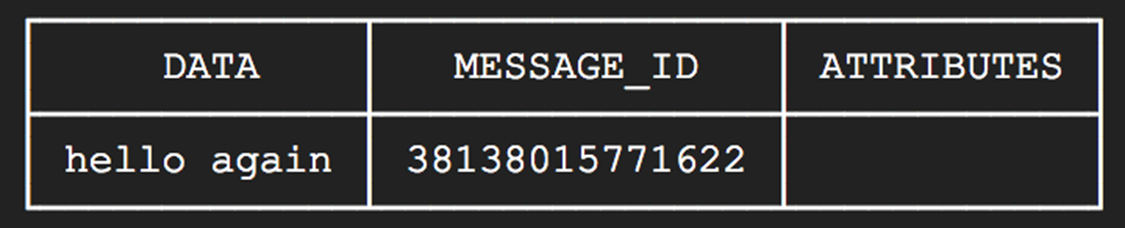

7.In the training-vm SSH terminal, cancel your subscription.
```shell
gcloud pubsub subscriptions delete mySub1
```

### Simulate traffic sensor data into Pub/Sub
1.Explore the python script to simulate San Diego traffic sensor data. Do not make any changes to the code. <br>
cd ~/training-data-analyst/courses/streaming/publish  <br>
nano send_sensor_data.py <br>
Look at the simulate function. This one lets the script behave as if traffic sensors were sending in data in real time  <br>
to Pub/Sub. The speedFactor parameter determines how fast the simulation will go. Exit the file by pressing Ctrl+X. <br>
2. Download the traffic simulation dataset. <br>
./download_data.sh <br>
Simulate streaming sensor data <br>
3.Run the send_sensor_data.py. <br>
./send_sensor_data.py --speedFactor=60 --project $DEVSHELL_PROJECT_ID <br>
This command simulates sensor data by sending recorded sensor data via Pub/Sub messages. The script extracts 
the original time of the sensor data and pauses between sending each message to simulate realistic timing of the 
sensor data. The value speedFactor changes the time between messages proportionally. So a speedFactor of 60 
means **"60 times faster"** than the recorded timing. It will send about an hour of data every 60 seconds.
Leave this terminal open and the simulator running. <br>


In [ ]:
import time
import gzip
import logging
import argparse
import datetime
from google.cloud import pubsub

TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
TOPIC = 'sandiego'
INPUT = 'sensor_obs2008.csv.gz'

def publish(publisher, topic, events):
   numobs = len(events)
   if numobs > 0:
       logging.info('Publishing {0} events from {1}'.format(numobs, get_timestamp(events[0])))
       for event_data in events:
         publisher.publish(topic,event_data)

def get_timestamp(line):
   ## convert from bytes to str
   line = line.decode('utf-8')

   # look at first field of row
   timestamp = line.split(',')[0]
   return datetime.datetime.strptime(timestamp, TIME_FORMAT)

def simulate(topic, ifp, firstObsTime, programStart, speedFactor):
   # sleep computation
   def compute_sleep_secs(obs_time):
        time_elapsed = (datetime.datetime.utcnow() - programStart).seconds
        sim_time_elapsed = ((obs_time - firstObsTime).days * 86400.0 + (obs_time - firstObsTime).seconds) / speedFactor
        to_sleep_secs = sim_time_elapsed - time_elapsed
        return to_sleep_secs

   topublish = list() 

   for line in ifp:
       event_data = line   # entire line of input CSV is the message
       obs_time = get_timestamp(line) # from first column

       # how much time should we sleep?
       if compute_sleep_secs(obs_time) > 1:
          # notify the accumulated topublish
          publish(publisher, topic, topublish) # notify accumulated messages
          topublish = list() # empty out list

          # recompute sleep, since notification takes a while
          to_sleep_secs = compute_sleep_secs(obs_time)
          if to_sleep_secs > 0:
             logging.info('Sleeping {} seconds'.format(to_sleep_secs))
             time.sleep(to_sleep_secs)
       topublish.append(event_data)

   # left-over records; notify again
   publish(publisher, topic, topublish)

def peek_timestamp(ifp):
   # peek ahead to next line, get timestamp and go back
   pos = ifp.tell()
   line = ifp.readline()
   ifp.seek(pos)
   return get_timestamp(line)


if __name__ == '__main__':
   parser = argparse.ArgumentParser(description='Send sensor data to Cloud Pub/Sub in small groups, simulating real-time behavior')
   parser.add_argument('--speedFactor', help='Example: 60 implies 1 hour of data sent to Cloud Pub/Sub in 1 minute', required=True, type=float)
   parser.add_argument('--project', help='Example: --project $DEVSHELL_PROJECT_ID', required=True)
   args = parser.parse_args()

   # create Pub/Sub notification topic
   logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)
   publisher = pubsub.PublisherClient()
   event_type = publisher.topic_path(args.project,TOPIC)
   try:
      publisher.get_topic(event_type)
      logging.info('Reusing pub/sub topic {}'.format(TOPIC))
   except:
      publisher.create_topic(event_type)
      logging.info('Creating pub/sub topic {}'.format(TOPIC))

   # notify about each line in the input file
   programStartTime = datetime.datetime.utcnow() 
   with gzip.open(INPUT, 'rb') as ifp:
      header = ifp.readline()  # skip header
      firstObsTime = peek_timestamp(ifp)
      logging.info('Sending sensor data from {}'.format(firstObsTime))
      simulate(event_type, ifp, firstObsTime, programStartTime, args.speedFactor)

### Verify that messages are received
✓ Open a second SSH terminal and connect to the training VM <br>
✓ cd ~/training-data-analyst/courses/streaming/publish <br>
✓ Create a subscription for the topic and do a pull to confirm that messages are  
coming in (note: you may need to issue the 'pull' command more than once to 
start seeing messages): <br>
gcloud pubsub subscriptions create --topic sandiego mySub2  <br>
gcloud pubsub subscriptions pull --auto-ack mySub2 <br>
Confirm that you see a message with traffic sensor information. <br>

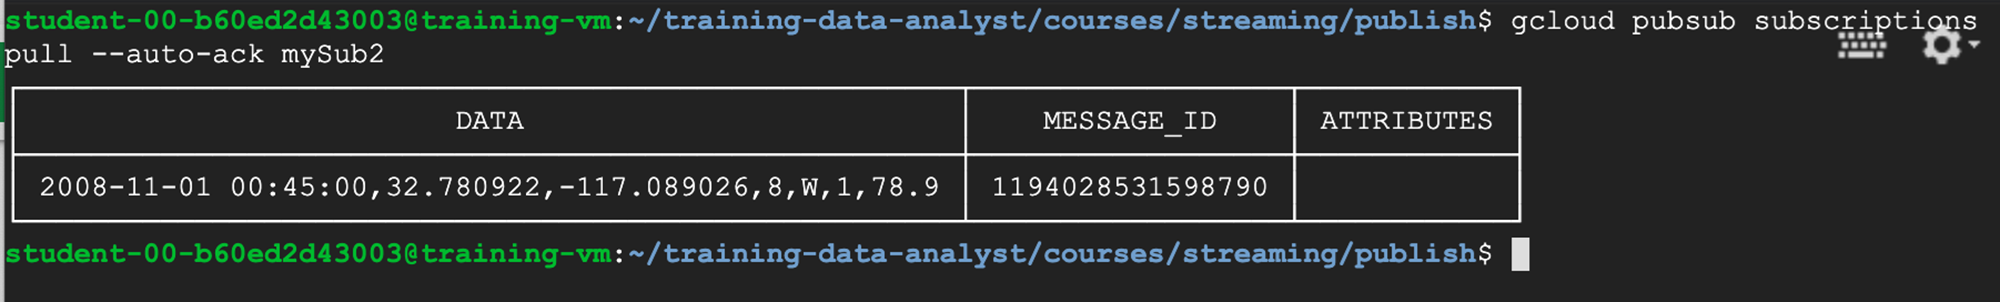

✓ Cancel this subscription. gcloud pubsub subscriptions delete mySub2 <br>
✓ Close the second terminal. <br>
✓ In first terminal Ctrl+C and exit it <br>